In [1]:
#@title Installs:

!pip install pretrainedmodels

!pip install torchlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 877 kB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=08a6ae64493a4a9c8bda7e03db3805d6205af6cc1f0cd7894c6082ffc6fdda56
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 2.0 MB/s 
     |████████████████████████████████| 13.1 MB 9.8 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 4.5 MB 25.8 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 


In [ ]:
!unzip "drive/MyDrive/_data/dataset_100.zip"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Import:

import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.utils.data as data
import scipy
import torch.nn.functional as F
import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import torch.optim as one
import matplotlib
import random
import time
import logging
import torchlm;

from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import transforms
from scipy.integrate import simps
from scipy.stats import norm
from math import floor

In [4]:
#@title Configuration:

class Config():
    def __init__(self):
        self.det_head = 'pip'
        self.net_stride = 32
        self.batch_size = 32
        self.init_lr = 0.00005
        self.num_epochs = 10
        self.decay_steps = [30, 50]
        self.input_size = 256
        self.backbone = 'resnet18'
        self.pretrained = True
        self.criterion_cls = 'l2'
        self.criterion_reg = 'l1'
        self.cls_loss_weight = 10
        self.reg_loss_weight = 1
        self.num_lms = 68
        self.save_interval = self.num_epochs
        self.num_nb = 10
        self.use_gpu = True
        self.gpu_id = 0
        self.data_dir = "drive/MyDrive/_data/dataset_100/"
        self.log_dir = "drive/MyDrive/machine-learning/"
        self.data_name = "pipnet_rn18/"
        self.experiment_name = None



cfg = Config()
cfg.experiment_name = "02"

In [5]:
#@title Data (Augmentation) Methods:

# Augmentation methods:
def random_translate(image, target, override = False):

    if override == True or random.random() > 0.5:
        image_height, image_width = image.size
        a = 1
        b = 0
        #c = 30 #left/right (i.e. 5/-5)
        c = int((random.random()-0.5) * 60)
        d = 0
        e = 1
        #f = 30 #up/down (i.e. 5/-5)
        f = int((random.random()-0.5) * 60)
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))
        target_translate = target.copy()
        target_translate = target_translate.reshape(-1, 2)
        target_translate[:, 0] -= 1.*c/image_width
        target_translate[:, 1] -= 1.*f/image_height
        target_translate = target_translate.flatten()
        target_translate[target_translate < 0] = 0
        target_translate[target_translate > 1] = 1
        return image, target_translate
    else:
        return image, target

def random_blur(image, override = False):
    if override == True or random.random() > 0.7:
        image = image.filter(ImageFilter.GaussianBlur(random.random()*5))
    return image

def random_occlusion(image, override = False):
    if override == True or random.random() > 0.5:
        image_np = np.array(image).astype(np.uint8)
        image_np = image_np[:,:,::-1]
        image_height, image_width, _ = image_np.shape
        occ_height = int(image_height*0.4*random.random())
        occ_width = int(image_width*0.4*random.random())
        occ_xmin = int((image_width - occ_width - 10) * random.random())
        occ_ymin = int((image_height - occ_height - 10) * random.random())
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 0] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 1] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 2] = int(random.random() * 255)
        image_pil = Image.fromarray(image_np[:,:,::-1].astype('uint8'), 'RGB')
        return image_pil
    else:
        return image

def random_rotate(image, target, angle_max, override = False):
    if override == True or random.random() > 0.5:
        center_x = 0.5
        center_y = 0.5
        landmark_num= int(len(target) / 2)
        target_center = np.array(target) - np.array([center_x, center_y]*landmark_num)
        target_center = target_center.reshape(landmark_num, 2)
        theta_max = np.radians(angle_max)
        theta = random.uniform(-theta_max, theta_max)
        angle = np.degrees(theta)
        image = image.rotate(angle)

        c, s = np.cos(theta), np.sin(theta)
        rot = np.array(((c,-s), (s, c)))
        target_center_rot = np.matmul(target_center, rot)
        target_rot = target_center_rot.reshape(landmark_num*2) + np.array([center_x, center_y]*landmark_num)
        return image, target_rot
    else:
        return image, target

def gen_target_pip(target, meanface_indices, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y):
    num_nb = len(meanface_indices[0])
    map_channel, map_height, map_width = target_map.shape
    target = target.reshape(-1, 2)
    assert map_channel == target.shape[0]

    for i in range(map_channel):
        mu_x = int(floor(target[i][0] * map_width))
        mu_y = int(floor(target[i][1] * map_height))
        mu_x = max(0, mu_x)
        mu_y = max(0, mu_y)
        mu_x = min(mu_x, map_width-1)
        mu_y = min(mu_y, map_height-1)
        target_map[i, mu_y, mu_x] = 1
        shift_x = target[i][0] * map_width - mu_x
        shift_y = target[i][1] * map_height - mu_y
        target_local_x[i, mu_y, mu_x] = shift_x
        target_local_y[i, mu_y, mu_x] = shift_y

        for j in range(num_nb):
            nb_x = target[meanface_indices[i][j]][0] * map_width - mu_x
            nb_y = target[meanface_indices[i][j]][1] * map_height - mu_y
            target_nb_x[num_nb*i+j, mu_y, mu_x] = nb_x
            target_nb_y[num_nb*i+j, mu_y, mu_x] = nb_y

    return target_map, target_local_x, target_local_y, target_nb_x, target_nb_y


In [6]:
#@title Dataset:

class ImageFolder_pip(data.Dataset):
    def __init__(self, root, imgs, input_size, num_lms, net_stride, meanface_indices, transform=None, target_transform=None):
        self.root = root
        self.imgs = imgs
        self.num_lms = num_lms
        self.net_stride = net_stride
        #self.points_flip = points_flip
        self.meanface_indices = meanface_indices
        self.num_nb = len(meanface_indices[0])
        self.transform = transform
        self.target_transform = target_transform
        self.input_size = input_size

    def __getitem__(self, index):

        img_name, target = self.imgs[index]

        img = Image.open(img_name).convert('RGB')

        img, target = random_translate(img, target)
        img = random_occlusion(img)
        img, target = random_rotate(img, target, 30)
        img = random_blur(img)

        target_map = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_local_x = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_local_y = np.zeros((self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_nb_x = np.zeros((self.num_nb*self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_nb_y = np.zeros((self.num_nb*self.num_lms, int(self.input_size/self.net_stride), int(self.input_size/self.net_stride)))
        target_map, target_local_x, target_local_y, target_nb_x, target_nb_y = gen_target_pip(target, self.meanface_indices, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y)
        
        target_map = torch.from_numpy(target_map).float()
        target_local_x = torch.from_numpy(target_local_x).float()
        target_local_y = torch.from_numpy(target_local_y).float()
        target_nb_x = torch.from_numpy(target_nb_x).float()
        target_nb_y = torch.from_numpy(target_nb_y).float()

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target_map = self.target_transform(target_map)
            target_local_x = self.target_transform(target_local_x)
            target_local_y = self.target_transform(target_local_y)
            target_nb_x = self.target_transform(target_nb_x)
            target_nb_y = self.target_transform(target_nb_y)

        return img, target_map, target_local_x, target_local_y, target_nb_x, target_nb_y

    def __len__(self):
        return len(self.imgs)

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F4917155160>


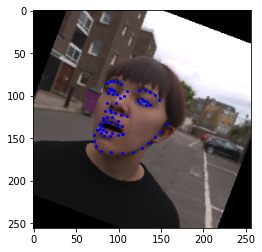

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F491722FF40>


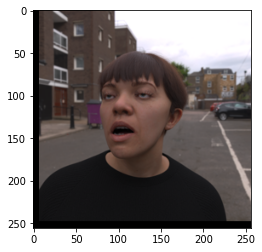

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F49173C5B20>


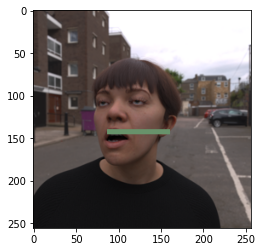

<PIL.Image.Image image mode=RGB size=256x256 at 0x7F4919BCFE20>


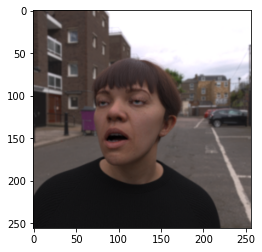

In [17]:
#@title Data Augmentation Testing:
# test data augmentation

image_path = "drive/MyDrive/_data/dataset_100/000009.png"
image = Image.open(image_path)
image = image.resize((cfg.input_size, cfg.input_size))

keypoints = get_keypoints_path(image_path)
keypoints = keypoints/512
keypoints = np.reshape(keypoints, (keypoints.shape[0]*2, 1))
keypoints = keypoints[:,0]
#image_augmented = random_translate(image)
#plt.imshow(image_augmented)
#plt.show()

image_augmented, target = random_rotate(image, keypoints, 30, True)
target = np.reshape(target,(len(target)//2, 2))
print(image_augmented)
plt.imshow(image_augmented)
plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
plt.show()

image_augmented, target = random_translate(image, keypoints, True)
print(image_augmented)
plt.imshow(image_augmented)
plt.show()

image_augmented = random_occlusion(image, True)
print(image_augmented)
plt.imshow(image_augmented)
plt.show()

image_augmented = random_blur(image, True)
print(image_augmented)
plt.imshow(image_augmented)
plt.show()


In [10]:
#@title Data Annotation:

def generate_meanface():
    custom_meanface, custom_meanface_string = torchlm.data.annotools.generate_meanface(
      annotation_path="data_annotated.txt",
      coordinates_already_normalized=True)
    
    with open('meanface.txt', 'w') as f:
      f.writelines(custom_meanface_string)

    rendered_meanface = torchlm.data.annotools.draw_meanface(
      meanface=custom_meanface, coordinates_already_normalized=True)
    
    cv2.imwrite("meanface.jpg", rendered_meanface)
    
    print(custom_meanface_string)

def get_keypoints(data_dir, file_name):
    #remove file extension from file_name
    idx = [idx for idx, x in enumerate(file_name) if x == '.']
    file_name = file_name[:idx[0]]
    #get name of keypoint file
    file_name = data_dir + file_name + "_ldmks.txt"
    #fetch file and extract keypoints as list of tuples
    keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
    keypoints = np.array(keypoints, dtype='float32')

    return keypoints

def get_keypoints_path(file_path):

    idx = [idx for idx, x in enumerate(file_path) if x == '.']
    file_name = file_path[:idx[0]]
    file_name = str(file_name) + "_ldmks.txt"
    keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
    keypoints = np.array(keypoints, dtype='float32')

    return keypoints



def form_datafile():
  # get all images in list:
  #im_list = np.array([])
  #for f in os.listdir(cfg.data_dir):
  #  if not '_seg' in f and not '_ldmks' in f and '.png' in f:
  #    im_list = np.append(im_list, f)

  train_list, valid_list = train_validate_split(cfg.data_dir, 0.1)

  lines = []
  for i in range(0, train_list.shape[0]):
    keypoints = get_keypoints(cfg.data_dir, train_list[i])
    keypoints = keypoints[:-2, :]
    keypoints = keypoints/512 # normalize coordinates
    keypoints = np.reshape(keypoints, (1, keypoints.shape[0]*2))
    line = ""
    for j in range(0, keypoints.shape[1]):
      val = keypoints[0,j]
      val = str(val)
      line += (" " + val) 

    if i == 0:
      lines.append(str(cfg.data_dir + train_list[i]) + line)
    else:
      lines.append("\n" + str(cfg.data_dir + train_list[i]) + line)
      
  with open('data_annotated.txt', 'w') as f:
    f.writelines(lines)


  lines = []
  for i in range(0, valid_list.shape[0]):
    keypoints = get_keypoints(cfg.data_dir, valid_list[i])
    keypoints = keypoints[:-2, :]
    keypoints = keypoints/512 # normalize coordinates
    keypoints = np.reshape(keypoints, (1, keypoints.shape[0]*2))
    line = ""
    for j in range(0, keypoints.shape[1]):
      val = keypoints[0,j]
      val = str(val)
      line += (" " + val) 

    if i == 0:
      lines.append(str(cfg.data_dir + valid_list[i]) + line)
    else:
      lines.append("\n" + str(cfg.data_dir + valid_list[i]) + line)
      
  with open('data_annotated_validation.txt', 'w') as f:
    f.writelines(lines)



form_datafile()
generate_meanface()

Generating meanface [data_annotated.txt]: 100%|██████████| 90/90 [00:00<00:00, 12422.25it/s]

0.3627226977777778 0.5068150184444443 0.3705758683333333 0.5535300573333335 0.37713394133333317 0.5909208766666668 0.3857438158888891 0.6303616762222222 0.3970913417777778 0.6627271519999999 0.41924756822222214 0.694103775 0.44944318600000005 0.7193499781111111 0.4821835705555558 0.7387297724444444 0.5173169056666663 0.7479331817777777 0.5508590518888887 0.7349820343333331 0.5763785138888886 0.7149757349999999 0.5996165365555555 0.6874180091111111 0.6134944202222221 0.6568439250000002 0.619771337333333 0.623873785 0.6244038219999999 0.5830023223333334 0.6276972896666668 0.5466920172222222 0.6321087023333333 0.4994363495555557 0.40930974188888875 0.4634854157777778 0.42580564422222245 0.4559295365555557 0.4465368065555555 0.45267923011111105 0.4655184035555556 0.45482879711111124 0.4846515803333334 0.4616845716666667 0.5485205758888889 0.4594605891111111 0.5662887363333334 0.45197938400000015 0.5848502383333332 0.44934641777777756 0.6003562916666667 0.45079837377777776 0.612639500777777

In [8]:
#@title Visualization
def show_points_validation(i, lms):
  image_path = labels_validate[i][0]

  lms = lms.detach().cpu().clone().numpy()

  image = cv2.imread(image_path)
  image = cv2.resize(image, (cfg.input_size, cfg.input_size))

  keypoints = get_keypoints_path(image_path)
  keypoints = keypoints/512

  preds = np.reshape(lms, (len(lms)//2, 2))

  plt.imshow(image)
  plt.plot(keypoints[:,0]*cfg.input_size,keypoints[:,1]*cfg.input_size, 'bo', markersize = 1)
  plt.plot(preds[:,0]*cfg.input_size,preds[:,1]*cfg.input_size, 'ro', markersize = 1)
  plt.show()  

  return



In [7]:
#@title Utility Functions:
def train_validate_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

def get_label(label_file, task_type=None):
    label_path = label_file
    with open(label_path, 'r') as f:
        labels = f.readlines()
    labels = [x.strip().split() for x in labels]
    if len(labels[0])==1:
        return labels

    labels_new = []
    for label in labels:
        image_name = label[0]
        target = label[1:]
        target = np.array([float(x) for x in target])
        if task_type is None:
            labels_new.append([image_name, target])
        else:
            labels_new.append([image_name, task_type, target])
    return labels_new

def get_meanface(meanface_file, num_nb):
    with open(meanface_file) as f:
        meanface = f.readlines()[0]
        
    meanface = meanface.strip().split()
    meanface = [float(x) for x in meanface]
    meanface = np.array(meanface).reshape(-1, 2)
    # each landmark predicts num_nb neighbors
    meanface_indices = []
    for i in range(meanface.shape[0]):
        pt = meanface[i,:]
        dists = np.sum(np.power(pt-meanface, 2), axis=1)
        indices = np.argsort(dists)
        meanface_indices.append(indices[1:1+num_nb])
    
    # each landmark predicted by X neighbors, X varies
    meanface_indices_reversed = {}
    for i in range(meanface.shape[0]):
        meanface_indices_reversed[i] = [[],[]]
    for i in range(meanface.shape[0]):
        for j in range(num_nb):
            meanface_indices_reversed[meanface_indices[i][j]][0].append(i)
            meanface_indices_reversed[meanface_indices[i][j]][1].append(j)
    
    max_len = 0
    for i in range(meanface.shape[0]):
        tmp_len = len(meanface_indices_reversed[i][0])
        if tmp_len > max_len:
            max_len = tmp_len
    
    # tricks, make them have equal length for efficient computation
    for i in range(meanface.shape[0]):
        tmp_len = len(meanface_indices_reversed[i][0])
        meanface_indices_reversed[i][0] += meanface_indices_reversed[i][0]*10
        meanface_indices_reversed[i][1] += meanface_indices_reversed[i][1]*10
        meanface_indices_reversed[i][0] = meanface_indices_reversed[i][0][:max_len]
        meanface_indices_reversed[i][1] = meanface_indices_reversed[i][1][:max_len]

    # make the indices 1-dim
    reverse_index1 = []
    reverse_index2 = []
    for i in range(meanface.shape[0]):
        reverse_index1 += meanface_indices_reversed[i][0]
        reverse_index2 += meanface_indices_reversed[i][1]
    return meanface_indices, reverse_index1, reverse_index2, max_len

def compute_loss_pip(outputs_map, outputs_local_x, outputs_local_y, outputs_nb_x, outputs_nb_y, labels_map, labels_local_x, labels_local_y, labels_nb_x, labels_nb_y,  criterion_cls, criterion_reg, num_nb):

    tmp_batch, tmp_channel, tmp_height, tmp_width = outputs_map.size()
    labels_map = labels_map.view(tmp_batch*tmp_channel, -1)
    labels_max_ids = torch.argmax(labels_map, 1)
    labels_max_ids = labels_max_ids.view(-1, 1)
    labels_max_ids_nb = labels_max_ids.repeat(1, num_nb).view(-1, 1)

    outputs_local_x = outputs_local_x.view(tmp_batch*tmp_channel, -1)
    outputs_local_x_select = torch.gather(outputs_local_x, 1, labels_max_ids)
    outputs_local_y = outputs_local_y.view(tmp_batch*tmp_channel, -1)
    outputs_local_y_select = torch.gather(outputs_local_y, 1, labels_max_ids)
    outputs_nb_x = outputs_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
    outputs_nb_x_select = torch.gather(outputs_nb_x, 1, labels_max_ids_nb)
    outputs_nb_y = outputs_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
    outputs_nb_y_select = torch.gather(outputs_nb_y, 1, labels_max_ids_nb)

    labels_local_x = labels_local_x.view(tmp_batch*tmp_channel, -1)
    labels_local_x_select = torch.gather(labels_local_x, 1, labels_max_ids)
    labels_local_y = labels_local_y.view(tmp_batch*tmp_channel, -1)
    labels_local_y_select = torch.gather(labels_local_y, 1, labels_max_ids)
    labels_nb_x = labels_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
    labels_nb_x_select = torch.gather(labels_nb_x, 1, labels_max_ids_nb)
    labels_nb_y = labels_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
    labels_nb_y_select = torch.gather(labels_nb_y, 1, labels_max_ids_nb)

    labels_map = labels_map.view(tmp_batch, tmp_channel, tmp_height, tmp_width)
    loss_map = criterion_cls(outputs_map, labels_map)
    loss_x = criterion_reg(outputs_local_x_select, labels_local_x_select)
    loss_y = criterion_reg(outputs_local_y_select, labels_local_y_select)
    loss_nb_x = criterion_reg(outputs_nb_x_select, labels_nb_x_select)
    loss_nb_y = criterion_reg(outputs_nb_y_select, labels_nb_y_select)
    return loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y

def train_model(det_head, net, train_loader, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, num_epochs, scheduler, save_dir, save_interval, device):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        logging.info('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        logging.info('-' * 10)
        epoch_loss = 0.0

        epoch_loss = fit(net, train_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs)
        validation_loss = validate(net, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs)

        if epoch%(save_interval-1) == 0 and epoch > 0:
            filename = os.path.join(save_dir, 'epoch%d.pth' % epoch)
            torch.save(net.state_dict(), filename)
            print(filename, 'saved')
        scheduler.step()

    return net

def fit(net, train_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs):
    print('Training')
    training_loss = 0.0
    net.train()
    for i, data in enumerate(train_loader):
        inputs, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y = data
        inputs = inputs.to(device)
        labels_map = labels_map.to(device)
        labels_x = labels_x.to(device)
        labels_y = labels_y.to(device)
        labels_nb_x = labels_nb_x.to(device)
        labels_nb_y = labels_nb_y.to(device)
        outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
        loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y = compute_loss_pip(outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, criterion_cls, criterion_reg, num_nb)
        loss = cls_loss_weight*loss_map + reg_loss_weight*loss_x + reg_loss_weight*loss_y + reg_loss_weight*loss_nb_x + reg_loss_weight*loss_nb_y

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i%10 == 0:
            print('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total training loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
            logging.info('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total training loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
    
        training_loss += loss.item()

    return training_loss/len(train_loader)


def validate(net, valid_loader, criterion_cls, criterion_reg, cls_loss_weight, reg_loss_weight, num_nb, optimizer, epoch, num_epochs):
    print('Validating')
    validation_loss = 0.0
    net.eval()
    nme = 0.0
    for i, data in enumerate(valid_loader):
            inputs, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y = data
            inputs = inputs.to(device)
            labels_map = labels_map.to(device)
            labels_x = labels_x.to(device)
            labels_y = labels_y.to(device)
            labels_nb_x = labels_nb_x.to(device)
            labels_nb_y = labels_nb_y.to(device)
            outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
            loss_map, loss_x, loss_y, loss_nb_x, loss_nb_y = compute_loss_pip(outputs_map, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y, labels_map, labels_x, labels_y, labels_nb_x, labels_nb_y, criterion_cls, criterion_reg, num_nb)
            loss = cls_loss_weight*loss_map + reg_loss_weight*loss_x + reg_loss_weight*loss_y + reg_loss_weight*loss_nb_x + reg_loss_weight*loss_nb_y

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i==0:
              # visualize:
              lms = get_landmarks(net, torch.unsqueeze(inputs.clone()[0], 0))
              nme = compute_nme_runtime(lms, i)
              print('NME: ', nme)
              show_points_validation(i, lms)

            if i%10 == 0:
                print('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total validation loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                    epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
                logging.info('[Epoch {:d}/{:d}, Batch {:d}/{:d}] <Total validation loss: {:.6f}> <map loss: {:.6f}> <x loss: {:.6f}> <y loss: {:.6f}> <nbx loss: {:.6f}> <nby loss: {:.6f}>'.format(
                    epoch, num_epochs-1, i, len(train_loader)-1, loss.item(), cls_loss_weight*loss_map.item(), reg_loss_weight*loss_x.item(), reg_loss_weight*loss_y.item(), reg_loss_weight*loss_nb_x.item(), reg_loss_weight*loss_nb_y.item()))
        
            validation_loss += loss.item()

    epoch_validation_loss = validation_loss/len(valid_loader)
    return epoch_validation_loss, nme


def forward_pip(net, inputs, input_size, net_stride, num_nb):
    net.eval()
    with torch.no_grad():
        outputs_cls, outputs_x, outputs_y, outputs_nb_x, outputs_nb_y = net(inputs)
        tmp_batch, tmp_channel, tmp_height, tmp_width = outputs_cls.size()
        print(tmp_batch)
        assert tmp_batch == 1

        outputs_cls = outputs_cls.view(tmp_batch*tmp_channel, -1)
        max_ids = torch.argmax(outputs_cls, 1)
        max_cls = torch.max(outputs_cls, 1)[0]
        max_ids = max_ids.view(-1, 1)
        max_ids_nb = max_ids.repeat(1, num_nb).view(-1, 1)

        outputs_x = outputs_x.view(tmp_batch*tmp_channel, -1)
        outputs_x_select = torch.gather(outputs_x, 1, max_ids)
        outputs_x_select = outputs_x_select.squeeze(1)
        outputs_y = outputs_y.view(tmp_batch*tmp_channel, -1)
        outputs_y_select = torch.gather(outputs_y, 1, max_ids)
        outputs_y_select = outputs_y_select.squeeze(1)

        outputs_nb_x = outputs_nb_x.view(tmp_batch*num_nb*tmp_channel, -1)
        outputs_nb_x_select = torch.gather(outputs_nb_x, 1, max_ids_nb)
        outputs_nb_x_select = outputs_nb_x_select.squeeze(1).view(-1, num_nb)
        outputs_nb_y = outputs_nb_y.view(tmp_batch*num_nb*tmp_channel, -1)
        outputs_nb_y_select = torch.gather(outputs_nb_y, 1, max_ids_nb)
        outputs_nb_y_select = outputs_nb_y_select.squeeze(1).view(-1, num_nb)

        tmp_x = (max_ids%tmp_width).view(-1,1).float()+outputs_x_select.view(-1,1)
        tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
        tmp_x /= 1.0 * input_size / net_stride
        tmp_y /= 1.0 * input_size / net_stride

        tmp_nb_x = (max_ids%tmp_width).view(-1,1).float()+outputs_nb_x_select
        tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select
        tmp_nb_x = tmp_nb_x.view(-1, num_nb)
        tmp_nb_y = tmp_nb_y.view(-1, num_nb)
        tmp_nb_x /= 1.0 * input_size / net_stride
        tmp_nb_y /= 1.0 * input_size / net_stride

    return tmp_x, tmp_y, tmp_nb_x, tmp_nb_y, outputs_cls, max_cls


def get_landmarks(net, inputs):

    lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(net, inputs, cfg.input_size, cfg.net_stride, cfg.num_nb)

    # merge neighbor predictions
    lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
    tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
    tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
    tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1,1)
    tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1,1)
    lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()

    return lms_pred_merge


def compute_nme(lms_pred, lms_gt, norm):
    lms_pred = lms_pred.reshape((-1, 2))
    lms_gt = lms_gt.reshape((-1, 2))
    print(np.linalg.norm(lms_pred - lms_gt, axis=1));
    nme = np.mean(np.linalg.norm(lms_pred - lms_gt, axis=1)) / norm 
    return nme

def compute_nme_runtime(lms_pred, idx):
    image_path = labels_validate[idx][0]
    keypoints = get_keypoints_path(image_path)
    keypoints = keypoints[:68,:]
    keypoints = keypoints/512
    
    preds = lms_pred.cuda().detach().cpu().clone().numpy()
    preds = np.reshape(preds, (len(preds)//2, 2))

    norm = np.linalg.norm(keypoints[36, ] - keypoints[45, ])

    nme = np.mean(np.linalg.norm(preds - keypoints, axis=1)) / norm 
    return nme

def compute_fr_and_auc(nmes, thres=0.1, step=0.0001):
    num_data = len(nmes)
    xs = np.arange(0, thres + step, step)
    ys = np.array([np.count_nonzero(nmes <= x) for x in xs]) / float(num_data)
    fr = 1.0 - ys[-1]
    auc = simps(ys, x=xs) / thres
    return fr, auc



In [9]:
#@title Model:
class Pip_resnet18(nn.Module):
    def __init__(self, resnet, num_nb, num_lms=68, input_size=256, net_stride=32):
        super(Pip_resnet18, self).__init__()
        self.num_nb = num_nb
        self.num_lms = num_lms
        self.input_size = input_size
        self.net_stride = net_stride
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.maxpool = resnet.maxpool
        self.sigmoid = nn.Sigmoid()
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        if self.net_stride == 128:
            self.layer5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn5 = nn.BatchNorm2d(512)
            self.layer6 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn6 = nn.BatchNorm2d(512)
            # init
            nn.init.normal_(self.layer5.weight, std=0.001)
            if self.layer5.bias is not None:
                nn.init.constant_(self.layer5.bias, 0)
            nn.init.constant_(self.bn5.weight, 1)
            nn.init.constant_(self.bn5.bias, 0)

            nn.init.normal_(self.layer6.weight, std=0.001)
            if self.layer6.bias is not None:
                nn.init.constant_(self.layer6.bias, 0)
            nn.init.constant_(self.bn6.weight, 1)
            nn.init.constant_(self.bn6.bias, 0)
        elif self.net_stride == 64:
            self.layer5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
            self.bn5 = nn.BatchNorm2d(512)
            # init
            nn.init.normal_(self.layer5.weight, std=0.001)
            if self.layer5.bias is not None:
                nn.init.constant_(self.layer5.bias, 0)
            nn.init.constant_(self.bn5.weight, 1)
            nn.init.constant_(self.bn5.bias, 0)
        elif self.net_stride == 32:
            pass
        elif self.net_stride == 16:
            self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False)
            self.bn_deconv1 = nn.BatchNorm2d(512)
            nn.init.normal_(self.deconv1.weight, std=0.001)
            if self.deconv1.bias is not None:
                nn.init.constant_(self.deconv1.bias, 0)
            nn.init.constant_(self.bn_deconv1.weight, 1)
            nn.init.constant_(self.bn_deconv1.bias, 0)
        else:
            print('No such net_stride!')
            exit(0)

        self.cls_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.x_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.y_layer = nn.Conv2d(512, num_lms, kernel_size=1, stride=1, padding=0)
        self.nb_x_layer = nn.Conv2d(512, num_nb*num_lms, kernel_size=1, stride=1, padding=0)
        self.nb_y_layer = nn.Conv2d(512, num_nb*num_lms, kernel_size=1, stride=1, padding=0)

        nn.init.normal_(self.cls_layer.weight, std=0.001)
        if self.cls_layer.bias is not None:
            nn.init.constant_(self.cls_layer.bias, 0)

        nn.init.normal_(self.x_layer.weight, std=0.001)
        if self.x_layer.bias is not None:
            nn.init.constant_(self.x_layer.bias, 0)

        nn.init.normal_(self.y_layer.weight, std=0.001)
        if self.y_layer.bias is not None:
            nn.init.constant_(self.y_layer.bias, 0)

        nn.init.normal_(self.nb_x_layer.weight, std=0.001)
        if self.nb_x_layer.bias is not None:
            nn.init.constant_(self.nb_x_layer.bias, 0)

        nn.init.normal_(self.nb_y_layer.weight, std=0.001)
        if self.nb_y_layer.bias is not None:
            nn.init.constant_(self.nb_y_layer.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.net_stride == 128:
            x = F.relu(self.bn5(self.layer5(x)))
            x = F.relu(self.bn6(self.layer6(x)))
        elif self.net_stride == 64:
            x = F.relu(self.bn5(self.layer5(x)))
        elif self.net_stride == 16:
            x = F.relu(self.bn_deconv1(self.deconv1(x)))
        else:
            pass
        x1 = self.cls_layer(x)
        x2 = self.x_layer(x)
        x3 = self.y_layer(x)
        x4 = self.nb_x_layer(x)
        x5 = self.nb_y_layer(x)
        return x1, x2, x3, x4, x5

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

True
Epoch 0/9
----------
Training
[Epoch 0/9, Batch 0/280] <Total training loss: 2.333985> <map loss: 0.169399> <x loss: 0.507187> <y loss: 0.513373> <nbx loss: 0.590946> <nby loss: 0.553079>
[Epoch 0/9, Batch 10/280] <Total training loss: 1.374340> <map loss: 0.146996> <x loss: 0.269977> <y loss: 0.276182> <nbx loss: 0.363553> <nby loss: 0.317632>
[Epoch 0/9, Batch 20/280] <Total training loss: 1.211747> <map loss: 0.142407> <x loss: 0.243966> <y loss: 0.236293> <nbx loss: 0.313768> <nby loss: 0.275312>
[Epoch 0/9, Batch 30/280] <Total training loss: 1.145732> <map loss: 0.136935> <x loss: 0.231840> <y loss: 0.219569> <nbx loss: 0.299528> <nby loss: 0.257861>
[Epoch 0/9, Batch 40/280] <Total training loss: 1.045926> <map loss: 0.129234> <x loss: 0.214333> <y loss: 0.199487> <nbx loss: 0.276825> <nby loss: 0.226047>
[Epoch 0/9, Batch 50/280] <Total training loss: 0.966316> <map loss: 0.122941> <x loss: 0.197982> <y loss: 0.179403> <nbx loss: 0.254233> <nby loss: 0.211757>
[Epoch 0/9, 

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


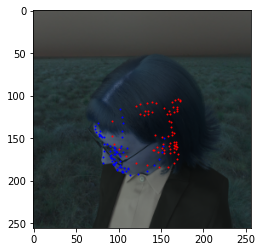

[Epoch 0/9, Batch 0/280] <Total validation loss: 0.367201> <map loss: 0.065863> <x loss: 0.076794> <y loss: 0.070431> <nbx loss: 0.078716> <nby loss: 0.075398>
[Epoch 0/9, Batch 10/280] <Total validation loss: 0.432718> <map loss: 0.071183> <x loss: 0.084261> <y loss: 0.089166> <nbx loss: 0.091140> <nby loss: 0.096968>
[Epoch 0/9, Batch 20/280] <Total validation loss: 0.393348> <map loss: 0.066725> <x loss: 0.075052> <y loss: 0.082108> <nbx loss: 0.080316> <nby loss: 0.089147>
[Epoch 0/9, Batch 30/280] <Total validation loss: 0.440031> <map loss: 0.071387> <x loss: 0.087811> <y loss: 0.092202> <nbx loss: 0.088532> <nby loss: 0.100099>
Epoch 1/9
----------
Training
[Epoch 1/9, Batch 0/280] <Total training loss: 0.456041> <map loss: 0.071016> <x loss: 0.095726> <y loss: 0.090819> <nbx loss: 0.101551> <nby loss: 0.096930>
[Epoch 1/9, Batch 10/280] <Total training loss: 0.448022> <map loss: 0.066459> <x loss: 0.089577> <y loss: 0.098830> <nbx loss: 0.093534> <nby loss: 0.099624>
[Epoch 1/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


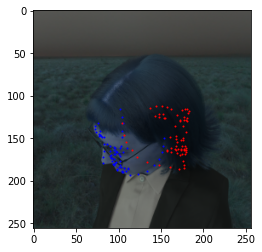

[Epoch 1/9, Batch 0/280] <Total validation loss: 0.341495> <map loss: 0.058912> <x loss: 0.070069> <y loss: 0.067191> <nbx loss: 0.074013> <nby loss: 0.071310>
[Epoch 1/9, Batch 10/280] <Total validation loss: 0.377892> <map loss: 0.064173> <x loss: 0.075085> <y loss: 0.075683> <nbx loss: 0.084336> <nby loss: 0.078615>
[Epoch 1/9, Batch 20/280] <Total validation loss: 0.339753> <map loss: 0.058662> <x loss: 0.064019> <y loss: 0.073605> <nbx loss: 0.068767> <nby loss: 0.074699>
[Epoch 1/9, Batch 30/280] <Total validation loss: 0.325052> <map loss: 0.059568> <x loss: 0.061186> <y loss: 0.069128> <nbx loss: 0.063683> <nby loss: 0.071486>
Epoch 2/9
----------
Training
[Epoch 2/9, Batch 0/280] <Total training loss: 0.315862> <map loss: 0.054915> <x loss: 0.068319> <y loss: 0.062078> <nbx loss: 0.069241> <nby loss: 0.061309>
[Epoch 2/9, Batch 10/280] <Total training loss: 0.397760> <map loss: 0.066352> <x loss: 0.083989> <y loss: 0.076633> <nbx loss: 0.092031> <nby loss: 0.078756>
[Epoch 2/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


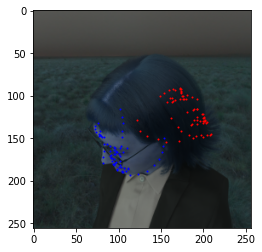

[Epoch 2/9, Batch 0/280] <Total validation loss: 0.280924> <map loss: 0.053518> <x loss: 0.059894> <y loss: 0.053842> <nbx loss: 0.059690> <nby loss: 0.053980>
[Epoch 2/9, Batch 10/280] <Total validation loss: 0.342701> <map loss: 0.059571> <x loss: 0.071409> <y loss: 0.066920> <nbx loss: 0.075100> <nby loss: 0.069702>
[Epoch 2/9, Batch 20/280] <Total validation loss: 0.268180> <map loss: 0.050062> <x loss: 0.053237> <y loss: 0.056065> <nbx loss: 0.053928> <nby loss: 0.054887>
[Epoch 2/9, Batch 30/280] <Total validation loss: 0.319242> <map loss: 0.054800> <x loss: 0.060517> <y loss: 0.069721> <nbx loss: 0.064108> <nby loss: 0.070097>
Epoch 3/9
----------
Training
[Epoch 3/9, Batch 0/280] <Total training loss: 0.338112> <map loss: 0.056765> <x loss: 0.062617> <y loss: 0.076743> <nbx loss: 0.063888> <nby loss: 0.078099>
[Epoch 3/9, Batch 10/280] <Total training loss: 0.289168> <map loss: 0.051136> <x loss: 0.055942> <y loss: 0.062379> <nbx loss: 0.057470> <nby loss: 0.062242>
[Epoch 3/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


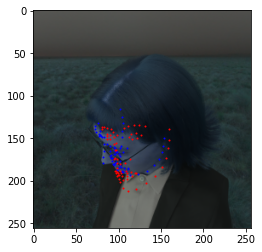

[Epoch 3/9, Batch 0/280] <Total validation loss: 0.246137> <map loss: 0.048049> <x loss: 0.048622> <y loss: 0.051248> <nbx loss: 0.048132> <nby loss: 0.050085>
[Epoch 3/9, Batch 10/280] <Total validation loss: 0.261515> <map loss: 0.050745> <x loss: 0.051103> <y loss: 0.053861> <nbx loss: 0.052523> <nby loss: 0.053283>
[Epoch 3/9, Batch 20/280] <Total validation loss: 0.283396> <map loss: 0.050914> <x loss: 0.059761> <y loss: 0.054609> <nbx loss: 0.063843> <nby loss: 0.054269>
[Epoch 3/9, Batch 30/280] <Total validation loss: 0.271180> <map loss: 0.048033> <x loss: 0.053648> <y loss: 0.056409> <nbx loss: 0.053512> <nby loss: 0.059578>
Epoch 4/9
----------
Training
[Epoch 4/9, Batch 0/280] <Total training loss: 0.278940> <map loss: 0.050080> <x loss: 0.057444> <y loss: 0.056338> <nbx loss: 0.057605> <nby loss: 0.057472>
[Epoch 4/9, Batch 10/280] <Total training loss: 0.285328> <map loss: 0.050553> <x loss: 0.057592> <y loss: 0.059158> <nbx loss: 0.059349> <nby loss: 0.058677>
[Epoch 4/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


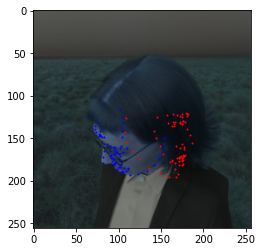

[Epoch 4/9, Batch 0/280] <Total validation loss: 0.257552> <map loss: 0.046749> <x loss: 0.053514> <y loss: 0.051580> <nbx loss: 0.053331> <nby loss: 0.052378>
[Epoch 4/9, Batch 10/280] <Total validation loss: 0.247348> <map loss: 0.046050> <x loss: 0.048880> <y loss: 0.050468> <nbx loss: 0.050269> <nby loss: 0.051682>
[Epoch 4/9, Batch 20/280] <Total validation loss: 0.263759> <map loss: 0.047937> <x loss: 0.057055> <y loss: 0.050294> <nbx loss: 0.058601> <nby loss: 0.049872>
[Epoch 4/9, Batch 30/280] <Total validation loss: 0.270685> <map loss: 0.049153> <x loss: 0.054658> <y loss: 0.055613> <nbx loss: 0.055989> <nby loss: 0.055272>
Epoch 5/9
----------
Training
[Epoch 5/9, Batch 0/280] <Total training loss: 0.266805> <map loss: 0.049589> <x loss: 0.054534> <y loss: 0.053867> <nbx loss: 0.056003> <nby loss: 0.052811>
[Epoch 5/9, Batch 10/280] <Total training loss: 0.271806> <map loss: 0.050385> <x loss: 0.052595> <y loss: 0.059169> <nbx loss: 0.052003> <nby loss: 0.057654>
[Epoch 5/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


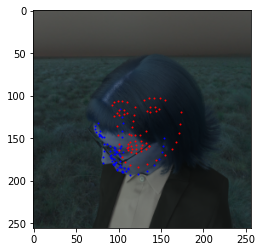

[Epoch 5/9, Batch 0/280] <Total validation loss: 0.239313> <map loss: 0.044425> <x loss: 0.044865> <y loss: 0.053066> <nbx loss: 0.044595> <nby loss: 0.052361>
[Epoch 5/9, Batch 10/280] <Total validation loss: 0.243293> <map loss: 0.045764> <x loss: 0.049411> <y loss: 0.048659> <nbx loss: 0.049398> <nby loss: 0.050061>
[Epoch 5/9, Batch 20/280] <Total validation loss: 0.263836> <map loss: 0.047996> <x loss: 0.051663> <y loss: 0.055293> <nbx loss: 0.053676> <nby loss: 0.055208>
[Epoch 5/9, Batch 30/280] <Total validation loss: 0.265705> <map loss: 0.048117> <x loss: 0.051826> <y loss: 0.055947> <nbx loss: 0.052964> <nby loss: 0.056851>
Epoch 6/9
----------
Training
[Epoch 6/9, Batch 0/280] <Total training loss: 0.267233> <map loss: 0.048011> <x loss: 0.054389> <y loss: 0.055461> <nbx loss: 0.054477> <nby loss: 0.054895>
[Epoch 6/9, Batch 10/280] <Total training loss: 0.239144> <map loss: 0.045564> <x loss: 0.047521> <y loss: 0.048490> <nbx loss: 0.048941> <nby loss: 0.048629>
[Epoch 6/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


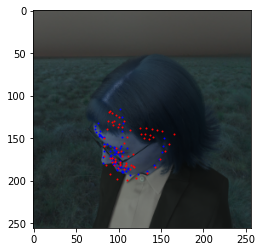

[Epoch 6/9, Batch 0/280] <Total validation loss: 0.244867> <map loss: 0.047089> <x loss: 0.050748> <y loss: 0.046899> <nbx loss: 0.053518> <nby loss: 0.046614>
[Epoch 6/9, Batch 10/280] <Total validation loss: 0.227663> <map loss: 0.042052> <x loss: 0.047023> <y loss: 0.045482> <nbx loss: 0.047367> <nby loss: 0.045739>
[Epoch 6/9, Batch 20/280] <Total validation loss: 0.256360> <map loss: 0.046919> <x loss: 0.047714> <y loss: 0.055711> <nbx loss: 0.047848> <nby loss: 0.058168>
[Epoch 6/9, Batch 30/280] <Total validation loss: 0.264453> <map loss: 0.046660> <x loss: 0.051384> <y loss: 0.057626> <nbx loss: 0.051098> <nby loss: 0.057685>
Epoch 7/9
----------
Training
[Epoch 7/9, Batch 0/280] <Total training loss: 0.258505> <map loss: 0.044876> <x loss: 0.055483> <y loss: 0.050135> <nbx loss: 0.058182> <nby loss: 0.049829>
[Epoch 7/9, Batch 10/280] <Total training loss: 0.304611> <map loss: 0.050798> <x loss: 0.054827> <y loss: 0.068210> <nbx loss: 0.058131> <nby loss: 0.072645>
[Epoch 7/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


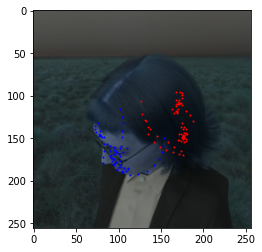

[Epoch 7/9, Batch 0/280] <Total validation loss: 0.245735> <map loss: 0.042933> <x loss: 0.047239> <y loss: 0.052883> <nbx loss: 0.048379> <nby loss: 0.054302>
[Epoch 7/9, Batch 10/280] <Total validation loss: 0.266827> <map loss: 0.046659> <x loss: 0.055544> <y loss: 0.051670> <nbx loss: 0.057600> <nby loss: 0.055353>
[Epoch 7/9, Batch 20/280] <Total validation loss: 0.250227> <map loss: 0.044650> <x loss: 0.047905> <y loss: 0.054323> <nbx loss: 0.050120> <nby loss: 0.053228>
[Epoch 7/9, Batch 30/280] <Total validation loss: 0.237684> <map loss: 0.043646> <x loss: 0.047314> <y loss: 0.048472> <nbx loss: 0.047720> <nby loss: 0.050531>
Epoch 8/9
----------
Training
[Epoch 8/9, Batch 0/280] <Total training loss: 0.245549> <map loss: 0.043631> <x loss: 0.050508> <y loss: 0.050911> <nbx loss: 0.050903> <nby loss: 0.049596>
[Epoch 8/9, Batch 10/280] <Total training loss: 0.243121> <map loss: 0.045883> <x loss: 0.046022> <y loss: 0.051652> <nbx loss: 0.047499> <nby loss: 0.052064>
[Epoch 8/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


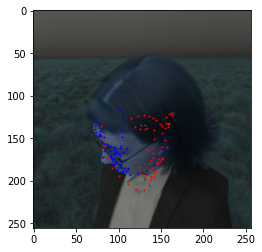

[Epoch 8/9, Batch 0/280] <Total validation loss: 0.220040> <map loss: 0.043213> <x loss: 0.043156> <y loss: 0.045199> <nbx loss: 0.043163> <nby loss: 0.045308>
[Epoch 8/9, Batch 10/280] <Total validation loss: 0.234306> <map loss: 0.043642> <x loss: 0.046665> <y loss: 0.047519> <nbx loss: 0.047473> <nby loss: 0.049007>
[Epoch 8/9, Batch 20/280] <Total validation loss: 0.225368> <map loss: 0.043900> <x loss: 0.043743> <y loss: 0.045221> <nbx loss: 0.045907> <nby loss: 0.046598>
[Epoch 8/9, Batch 30/280] <Total validation loss: 0.246716> <map loss: 0.043412> <x loss: 0.046921> <y loss: 0.052755> <nbx loss: 0.049179> <nby loss: 0.054448>
Epoch 9/9
----------
Training
[Epoch 9/9, Batch 0/280] <Total training loss: 0.266000> <map loss: 0.045689> <x loss: 0.048636> <y loss: 0.058593> <nbx loss: 0.050668> <nby loss: 0.062414>
[Epoch 9/9, Batch 10/280] <Total training loss: 0.231969> <map loss: 0.041117> <x loss: 0.047371> <y loss: 0.046928> <nbx loss: 0.048622> <nby loss: 0.047931>
[Epoch 9/9

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


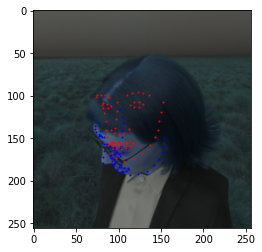

[Epoch 9/9, Batch 0/280] <Total validation loss: 0.214563> <map loss: 0.039632> <x loss: 0.042514> <y loss: 0.045273> <nbx loss: 0.042283> <nby loss: 0.044861>
[Epoch 9/9, Batch 10/280] <Total validation loss: 0.213433> <map loss: 0.041206> <x loss: 0.042160> <y loss: 0.044496> <nbx loss: 0.042860> <nby loss: 0.042711>
[Epoch 9/9, Batch 20/280] <Total validation loss: 0.230153> <map loss: 0.044322> <x loss: 0.044518> <y loss: 0.047699> <nbx loss: 0.045260> <nby loss: 0.048353>
[Epoch 9/9, Batch 30/280] <Total validation loss: 0.212693> <map loss: 0.039911> <x loss: 0.043243> <y loss: 0.043745> <nbx loss: 0.042796> <nby loss: 0.042998>
drive/MyDrive/machine-learning/pipnet_rn18/01/epoch9.pth saved


Pip_resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
#@title Training:

# directory initiation:
if not os.path.exists(os.path.join(cfg.log_dir, cfg.data_name)):
    os.mkdir(os.path.join(cfg.log_dir, cfg.data_name))

save_dir = os.path.join(cfg.log_dir, cfg.data_name, cfg.experiment_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

if not os.path.exists(os.path.join(save_dir, '/logs/')):
    os.mkdir(os.path.join(save_dir, '/logs/'))

log_dir = os.path.join(save_dir, '/logs/', cfg.experiment_name)
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

# logging:
logging.basicConfig(filename=os.path.join(log_dir, 'train.log'), level=logging.INFO)


meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface('meanface.txt', cfg.num_nb)

if cfg.backbone == 'resnet18':
  resnet18 = models.resnet18(pretrained=cfg.pretrained)
  net = Pip_resnet18(resnet18, cfg.num_nb, num_lms=cfg.num_lms, input_size=cfg.input_size, net_stride=cfg.net_stride)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
net = net.to(device)

criterion_cls = None
if cfg.criterion_cls == 'l2':
    criterion_cls = nn.MSELoss()
elif cfg.criterion_cls == 'l1':
    criterion_cls = nn.L1Loss()

criterion_reg = None
if cfg.criterion_reg == 'l1':
    criterion_reg = nn.L1Loss()
elif cfg.criterion_reg == 'l2':
    criterion_reg = nn.MSELoss()


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

if cfg.pretrained:  
    optimizer = optim.Adam(net.parameters(), lr=cfg.init_lr)
else:
    optimizer = optim.Adam(net.parameters(), lr=cfg.init_lr, weight_decay=5e-4)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=cfg.decay_steps, gamma=0.1)

labels_train = get_label("data_annotated.txt")
labels_validate = get_label("data_annotated_validation.txt")

if cfg.det_head == 'pip':
    train_data = ImageFolder_pip(cfg.data_dir, 
                            labels_train, cfg.input_size, cfg.num_lms, 
                            cfg.net_stride, meanface_indices,
                            transforms.Compose([
                            transforms.RandomGrayscale(0.2),
                            transforms.Resize(cfg.input_size),
                            transforms.ToTensor(),
                            normalize]))
    
    valid_data = ImageFolder_pip(cfg.data_dir, 
                            labels_validate, cfg.input_size, cfg.num_lms, 
                            cfg.net_stride, meanface_indices,
                            transforms.Compose([
                            transforms.RandomGrayscale(0.2),
                            transforms.Resize(cfg.input_size),
                            transforms.ToTensor(),
                            normalize]))
else:
    print('No such head:', cfg.det_head)
    exit(0)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=cfg.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)


train_model(cfg.det_head, net, train_loader, valid_loader, criterion_cls, criterion_reg, cfg.cls_loss_weight, cfg.reg_loss_weight, cfg.num_nb, optimizer, cfg.num_epochs, scheduler, save_dir, cfg.save_interval, device)



0.2025415889808374
1
[0.00297033 0.00929981 0.0115046  0.00620359 0.00659459 0.01105838
 0.00351973 0.00398703 0.007498   0.00553282 0.00317362 0.01698272
 0.00356027 0.0035902  0.00965742 0.01556694 0.01605379 0.00852546
 0.00601764 0.00200945 0.00351961 0.00183522 0.00286594 0.0050092
 0.00600369 0.00470944 0.00442596 0.00606167 0.00790628 0.00689204
 0.00700166 0.00894875 0.0050506  0.00301423 0.00232382 0.0076068
 0.00367673 0.00105083 0.00173854 0.00018371 0.00234945 0.00469032
 0.00518833 0.00310732 0.00376874 0.00422704 0.0038215  0.00144566
 0.00917999 0.00925157 0.00553842 0.00074694 0.00484397 0.00306621
 0.00597185 0.00526071 0.00271222 0.00280592 0.00435529 0.00588648
 0.00841017 0.0074913  0.00843208 0.00421227 0.00726438 0.00107197
 0.00049232 0.00284926]
[0.00477146 0.00740772 0.01123307 0.00763649 0.00656979 0.00854183
 0.00444275 0.00322314 0.00400949 0.00395855 0.00347129 0.00906188
 0.01044639 0.00538968 0.00747445 0.01155846 0.01697431 0.00591451
 0.00457078 0.00257

<ipython-input-10-a9e672f83a48>:234: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_y = (max_ids//tmp_width).view(-1,1).float()+outputs_y_select.view(-1,1)
<ipython-input-10-a9e672f83a48>:239: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  tmp_nb_y = (max_ids//tmp_width).view(-1,1).float()+outputs_nb_y_select


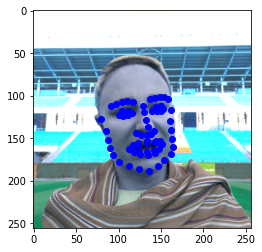

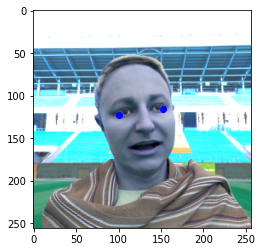

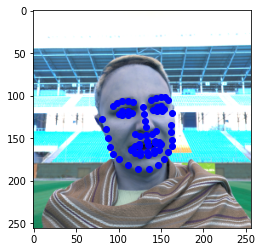

Total inference time: 0.009221315383911133
Image num: 9001
Average inference time: 1.0244767674604081e-06
nme: 0.026614662339030756
fr : 0.0
auc: 0.7336666666666666


In [ ]:
#@title Testing (Incomplete):

# this is still incomplete

load_weights = False

meanface_indices, reverse_index1, reverse_index2, max_len = get_meanface('meanface.txt', cfg.num_nb)
    
if load_weights:
  resnet18 = models.resnet18(pretrained=cfg.pretrained)
  net = Pip_resnet18(resnet18, cfg.num_nb, num_lms=cfg.num_lms, input_size=cfg.input_size, net_stride=cfg.net_stride)
  weight_file = os.path.join(save_dir, 'epoch%d.pth' % (cfg.num_epochs-1))
  state_dict = torch.load(weight_file)
  net.load_state_dict(state_dict)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([transforms.Resize((cfg.input_size, cfg.input_size)), transforms.ToTensor(), normalize])

norm_indices = [36, 45]

labels = get_label("data_annotated.txt")
label = labels[12]

nmes_std = []
nmes_merge = []
norm = None
time_all = 0

#for label in labels:
image_name = label[0]
lms_gt = label[1]
#print(lms_gt)

#image_name = "drive/MyDrive/_data/outdoor_001.png"
#keyname = "drive/MyDrive/_data/outdoor_001.pts"
#keypoints = np.loadtxt(keyname, dtype=float, comments=("version:", "n_points:", "{", "}"))

image_path = image_name
image = cv2.imread(image_path)

#keypoints[:,0] = keypoints[:,0]/image.shape[1]
#keypoints[:,1] = keypoints[:,1]/image.shape[0]
#lms_gt = np.reshape(keypoints, (keypoints.shape[0]*2, 1))
#lms_gt = lms_gt[:,0]

norm = np.linalg.norm(lms_gt.reshape(-1, 2)[norm_indices[0]] - lms_gt.reshape(-1, 2)[norm_indices[1]])
print(norm)

image = cv2.resize(image, (cfg.input_size, cfg.input_size))
inputs = Image.fromarray(image[:,:,::-1].astype('uint8'), 'RGB')
inputs = preprocess(inputs).unsqueeze(0)
inputs = inputs.to(device)
t1 = time.time()

lms_pred_x, lms_pred_y, lms_pred_nb_x, lms_pred_nb_y, outputs_cls, max_cls = forward_pip(net, inputs, cfg.input_size, cfg.net_stride, cfg.num_nb)


# merge neighbor predictions
lms_pred = torch.cat((lms_pred_x, lms_pred_y), dim=1).flatten()
tmp_nb_x = lms_pred_nb_x[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
tmp_nb_y = lms_pred_nb_y[reverse_index1, reverse_index2].view(cfg.num_lms, max_len)
tmp_x = torch.mean(torch.cat((lms_pred_x, tmp_nb_x), dim=1), dim=1).view(-1,1)
tmp_y = torch.mean(torch.cat((lms_pred_y, tmp_nb_y), dim=1), dim=1).view(-1,1)
lms_pred_merge = torch.cat((tmp_x, tmp_y), dim=1).flatten()

t2 = time.time()
time_all += (t2-t1)


lms_pred = lms_pred.cpu().numpy()
lms_pred_merge = lms_pred_merge.cpu().numpy()

nme_std = compute_nme(lms_pred, lms_gt, norm)
nmes_std.append(nme_std)

nme_merge = compute_nme(lms_pred_merge, lms_gt, norm)
nmes_merge.append(nme_merge)



preds = np.reshape(lms_pred, (len(lms_pred)//2, 2))
truths = np.reshape(lms_gt, (len(lms_gt)//2, 2))

plt.imshow(image)
plt.plot(truths[:,0]*cfg.input_size,truths[:,1]*cfg.input_size, 'bo')
plt.show()  

plt.imshow(image)
plt.plot(truths[36,0]*cfg.input_size,truths[36,1]*cfg.input_size, 'bo')
plt.plot(truths[45,0]*cfg.input_size,truths[45,1]*cfg.input_size, 'bo')
plt.show()  

plt.imshow(image)
plt.plot(preds[:,0]*cfg.input_size,preds[:,1]*cfg.input_size, 'bo')
plt.show()  



print('Total inference time:', time_all)
print('Image num:', len(labels))
print('Average inference time:', time_all/len(labels))


print('nme: {}'.format(np.mean(nmes_merge)))
logging.info('nme: {}'.format(np.mean(nmes_merge)))

fr, auc = compute_fr_and_auc(nmes_merge)
print('fr : {}'.format(fr))
logging.info('fr : {}'.format(fr))
print('auc: {}'.format(auc))
logging.info('auc: {}'.format(auc))